# Generative Adversarial Networks (GANs)


In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/da

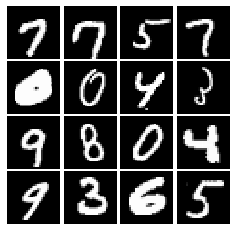

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See [here](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [9]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha*x, x)
     
    
     


Test your leaky ReLU implementation. You should get errors < 1e-10

In [10]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [21]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    noise = tf.random.uniform((batch_size, dim), minval=-1, maxval=1)
    return noise


Make sure noise is the correct shape and type:

In [22]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [38]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.layers.Dense(units=256)
        fc2 = tf.layers.Dense(units=256)
        fc3 = tf.layers.Dense(units=1)
        logits = fc1(x)
        logits = tf.nn.leaky_relu(logits, alpha=0.01)
        logits = fc2(logits)
        logits = tf.nn.leaky_relu(logits, alpha=0.01)
        logits = fc3(logits)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [39]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [40]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.Dense(units=1024)
        fc2 = tf.layers.Dense(units=1024)
        fc3 = tf.layers.Dense(units=784)
        img = fc1(z)
        img = tf.nn.relu(img)
        img = fc2(img)
        img = tf.nn.relu(img)
        img = fc3(img)
        img = tf.nn.tanh(img)
        return img

Test to make sure the number of parameters in the generator is correct:

In [41]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [60]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
    D_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    D_loss = D_real + D_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [61]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 6.02597e-17
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [62]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                        beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                        beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [63]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [64]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

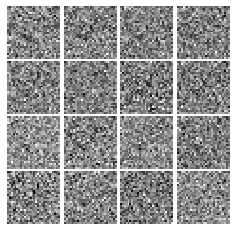


Iter: 0, D: 1.106, G:0.7072
Iter: 50, D: 0.2307, G:1.933
Iter: 100, D: 1.204, G:1.886
Iter: 150, D: 1.545, G:1.35
Iter: 200, D: 1.291, G:1.472


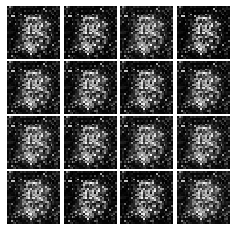


Iter: 250, D: 1.227, G:1.669
Iter: 300, D: 1.284, G:1.39
Iter: 350, D: 0.8452, G:2.208
Iter: 400, D: 2.768, G:0.9157
Iter: 450, D: 1.111, G:1.022


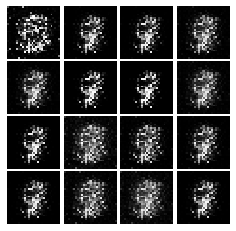


Iter: 500, D: 1.493, G:0.8073
Iter: 550, D: 1.135, G:1.247
Iter: 600, D: 1.147, G:1.411
Iter: 650, D: 1.092, G:1.38
Iter: 700, D: 1.299, G:0.8873


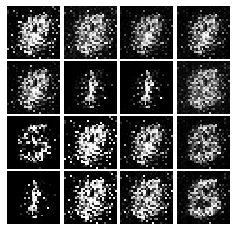


Iter: 750, D: 1.05, G:1.504
Iter: 800, D: 1.484, G:1.099
Iter: 850, D: 1.243, G:1.06
Iter: 900, D: 1.218, G:1.186
Iter: 950, D: 1.792, G:0.706


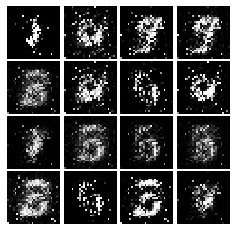


Iter: 1000, D: 1.406, G:1.463
Iter: 1050, D: 1.322, G:1.222
Iter: 1100, D: 1.411, G:1.194
Iter: 1150, D: 1.345, G:1.071
Iter: 1200, D: 1.261, G:1.445


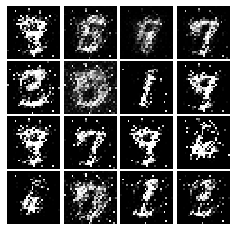


Iter: 1250, D: 1.2, G:0.8823
Iter: 1300, D: 0.9092, G:2.165
Iter: 1350, D: 1.18, G:1.011
Iter: 1400, D: 1.033, G:2.117
Iter: 1450, D: 1.237, G:1.102


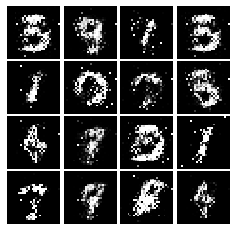


Iter: 1500, D: 1.674, G:0.7825
Iter: 1550, D: 1.12, G:1.033
Iter: 1600, D: 1.334, G:1.044
Iter: 1650, D: 1.343, G:1.018
Iter: 1700, D: 1.286, G:0.8599


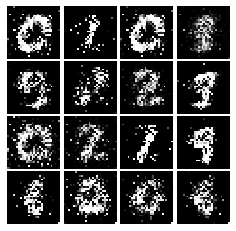


Iter: 1750, D: 1.3, G:0.8252
Iter: 1800, D: 1.366, G:0.819
Iter: 1850, D: 1.368, G:0.8392
Iter: 1900, D: 1.33, G:0.858
Iter: 1950, D: 1.28, G:0.8793


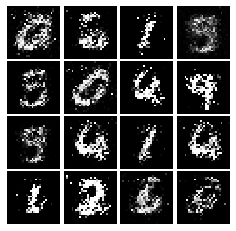


Iter: 2000, D: 1.342, G:0.8025
Iter: 2050, D: 1.34, G:0.851
Iter: 2100, D: 1.375, G:0.9289
Iter: 2150, D: 1.449, G:0.8983
Iter: 2200, D: 1.336, G:0.8959


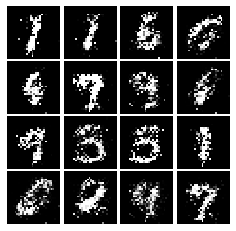


Iter: 2250, D: 1.357, G:0.7522
Iter: 2300, D: 1.316, G:0.8275
Iter: 2350, D: 1.321, G:0.7951
Iter: 2400, D: 1.309, G:0.8783
Iter: 2450, D: 1.365, G:0.7746


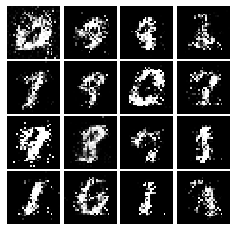


Iter: 2500, D: 1.236, G:0.9837
Iter: 2550, D: 1.329, G:0.8965
Iter: 2600, D: 1.451, G:0.8211
Iter: 2650, D: 1.369, G:0.4046
Iter: 2700, D: 1.217, G:1.021


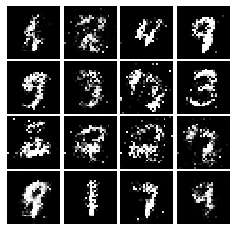


Iter: 2750, D: 1.262, G:1.052
Iter: 2800, D: 1.323, G:0.9077
Iter: 2850, D: 1.317, G:0.7762
Iter: 2900, D: 1.244, G:0.9131
Iter: 2950, D: 1.35, G:0.5145


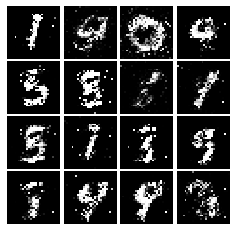


Iter: 3000, D: 1.257, G:1.104
Iter: 3050, D: 1.304, G:0.4942
Iter: 3100, D: 1.392, G:0.8594
Iter: 3150, D: 1.236, G:0.8632
Iter: 3200, D: 1.333, G:0.8147


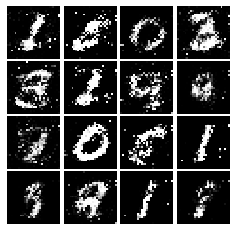


Iter: 3250, D: 1.316, G:0.9162
Iter: 3300, D: 1.308, G:0.9274
Iter: 3350, D: 1.286, G:0.9252
Iter: 3400, D: 1.294, G:0.9563
Iter: 3450, D: 1.297, G:0.7472


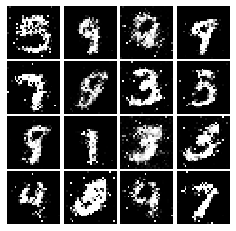


Iter: 3500, D: 1.248, G:0.9092
Iter: 3550, D: 1.31, G:0.8502
Iter: 3600, D: 1.351, G:0.9837
Iter: 3650, D: 1.293, G:0.8788
Iter: 3700, D: 1.3, G:0.8533


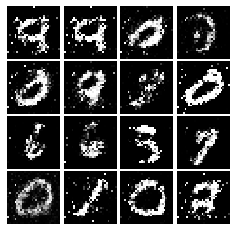


Iter: 3750, D: 1.362, G:0.7904
Iter: 3800, D: 1.369, G:0.7023
Iter: 3850, D: 1.331, G:0.8223
Iter: 3900, D: 1.339, G:1.003
Iter: 3950, D: 1.338, G:0.8093


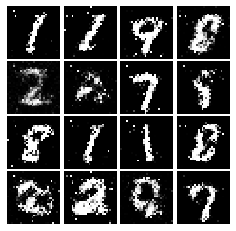


Iter: 4000, D: 1.304, G:0.8452
Iter: 4050, D: 1.265, G:0.8165
Iter: 4100, D: 1.297, G:0.7526
Iter: 4150, D: 1.315, G:0.7986
Iter: 4200, D: 1.365, G:0.7747


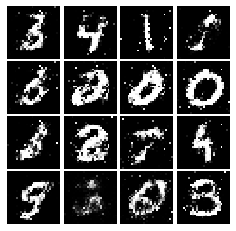


Iter: 4250, D: 1.304, G:0.82
Final images


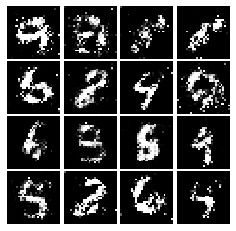

In [65]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [66]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(0.5*(score_real-1)**2 + 0.5*score_fake**2)
    G_loss = tf.reduce_mean(0.5*(score_fake-1)**2)
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [67]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [68]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

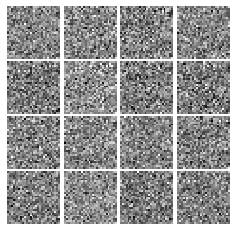


Iter: 0, D: 2.577, G:0.3957
Iter: 50, D: 0.01419, G:0.6219
Iter: 100, D: 0.0597, G:0.6023
Iter: 150, D: 0.106, G:0.586
Iter: 200, D: 0.2112, G:0.12


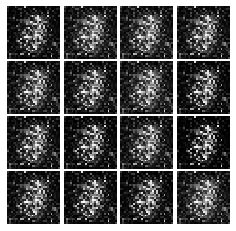


Iter: 250, D: 0.1139, G:0.3484
Iter: 300, D: 0.08052, G:0.4951
Iter: 350, D: 0.07013, G:0.6532
Iter: 400, D: 0.1848, G:0.5324
Iter: 450, D: 0.1266, G:0.3393


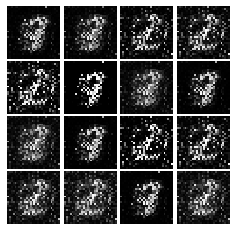


Iter: 500, D: 0.1301, G:0.5774
Iter: 550, D: 0.1163, G:0.3933
Iter: 600, D: 0.1122, G:0.485
Iter: 650, D: 0.1791, G:0.4191
Iter: 700, D: 0.1556, G:0.3021


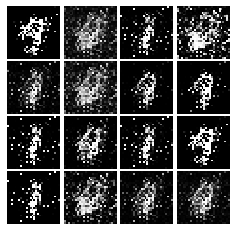


Iter: 750, D: 0.1023, G:0.4607
Iter: 800, D: 0.09457, G:0.469
Iter: 850, D: 0.1023, G:0.527
Iter: 900, D: 0.1559, G:0.4182
Iter: 950, D: 0.08095, G:0.5102


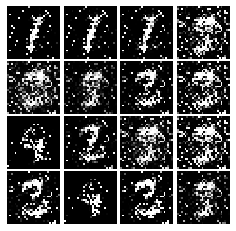


Iter: 1000, D: 0.1282, G:2.795
Iter: 1050, D: 0.08517, G:0.4134
Iter: 1100, D: 0.213, G:0.108
Iter: 1150, D: 0.1575, G:0.2921
Iter: 1200, D: 0.1236, G:0.432


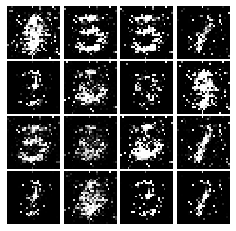


Iter: 1250, D: 0.1561, G:0.4443
Iter: 1300, D: 0.1896, G:0.5132
Iter: 1350, D: 0.1822, G:0.2948
Iter: 1400, D: 0.178, G:0.3058
Iter: 1450, D: 0.1594, G:0.2486


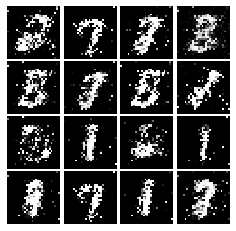


Iter: 1500, D: 0.1745, G:0.2473
Iter: 1550, D: 0.2054, G:0.1677
Iter: 1600, D: 0.19, G:0.2268
Iter: 1650, D: 0.2028, G:0.2101
Iter: 1700, D: 0.1883, G:0.2079


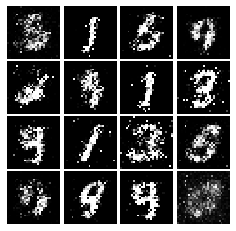


Iter: 1750, D: 0.2509, G:0.3958
Iter: 1800, D: 0.2195, G:0.2161
Iter: 1850, D: 0.2096, G:0.197
Iter: 1900, D: 0.2074, G:0.2095
Iter: 1950, D: 0.1943, G:0.2265


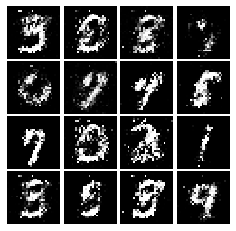


Iter: 2000, D: 0.2229, G:0.2046
Iter: 2050, D: 0.1849, G:0.2568
Iter: 2100, D: 0.2087, G:0.3026
Iter: 2150, D: 0.2054, G:0.2296
Iter: 2200, D: 0.2167, G:0.2182


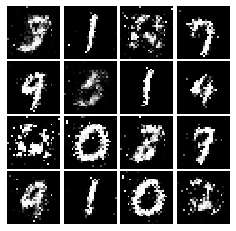


Iter: 2250, D: 0.2177, G:0.171
Iter: 2300, D: 0.2365, G:0.1799
Iter: 2350, D: 0.2324, G:0.1572
Iter: 2400, D: 0.2457, G:0.1667
Iter: 2450, D: 0.1991, G:0.193


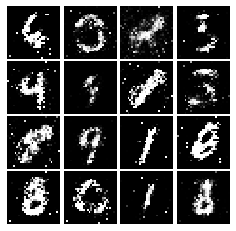


Iter: 2500, D: 0.2222, G:0.09623
Iter: 2550, D: 0.2172, G:0.2117
Iter: 2600, D: 0.2139, G:0.207
Iter: 2650, D: 0.196, G:0.1876
Iter: 2700, D: 0.1913, G:0.2067


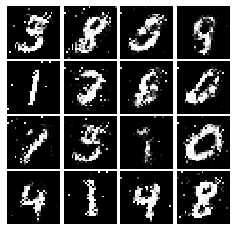


Iter: 2750, D: 0.2144, G:0.2157
Iter: 2800, D: 0.1944, G:0.1747
Iter: 2850, D: 0.2123, G:0.2148
Iter: 2900, D: 0.2258, G:0.1762
Iter: 2950, D: 0.1873, G:0.1983


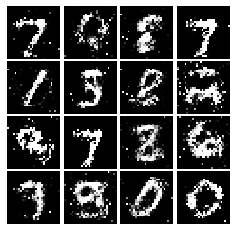


Iter: 3000, D: 0.1987, G:0.1911
Iter: 3050, D: 0.2259, G:0.2521
Iter: 3100, D: 0.2343, G:0.184
Iter: 3150, D: 0.2146, G:0.1706
Iter: 3200, D: 0.2151, G:0.1671


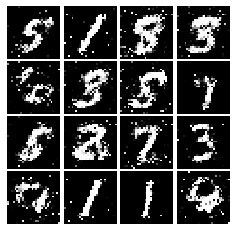


Iter: 3250, D: 0.2306, G:0.1823
Iter: 3300, D: 0.2015, G:0.2185
Iter: 3350, D: 0.1972, G:0.1647
Iter: 3400, D: 0.2188, G:0.1864
Iter: 3450, D: 0.2051, G:0.1818


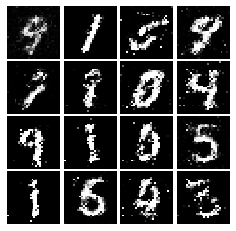


Iter: 3500, D: 0.21, G:0.1699
Iter: 3550, D: 0.1983, G:0.1734
Iter: 3600, D: 0.2224, G:0.1823
Iter: 3650, D: 0.2159, G:0.1883
Iter: 3700, D: 0.1912, G:0.1603


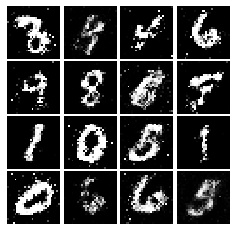


Iter: 3750, D: 0.1961, G:0.1911
Iter: 3800, D: 0.2119, G:0.221
Iter: 3850, D: 0.2168, G:0.2142
Iter: 3900, D: 0.2223, G:0.1448
Iter: 3950, D: 0.2164, G:0.1919


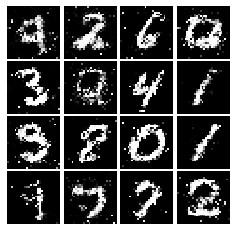


Iter: 4000, D: 0.2242, G:0.1975
Iter: 4050, D: 0.2286, G:0.1883
Iter: 4100, D: 0.2292, G:0.1712
Iter: 4150, D: 0.217, G:0.1761
Iter: 4200, D: 0.2041, G:0.1722


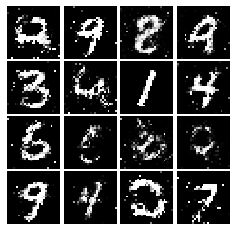


Iter: 4250, D: 0.2057, G:0.1543
Final images


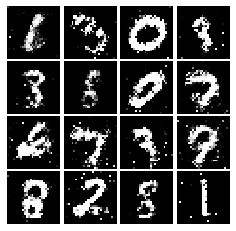

In [69]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

We can see that the samples gets less noisy over training. With at the start the image being full of noise and at the end we can see the numbers quite clearly with minimal noise. The distribution of the samples are quite spread across all numbers at the end, while at the start we can see that the inital images tend to have values that have a circle in them. for example, 0 or 8 or 9

# Deep Convolutional GANs  [Face Generator]
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.+

## Setup
Used Libraries:
* matplotlib
* PIL / Pillow
* numpy
* requests
* tqdm
* TensorFlow

## The CelebA Dataset

The CelebFaces Attributes Dataset dataset contains over 200,000 celebrity images each with 40 attribute annotations. At this point, we are also going to define to function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. To get some better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their values are in a range from -0,5 to +0,5. At last, we are going to downscale the images to 28x28 after that.

A helper function will automatically download the CelebA dataset to get you up and running quickly. Be sure to have tqdm installed. The download is 1.7GB large, so be sure to have enough disk space and a stable internet connection ready.

In [70]:
import helper

data_dir = './data'
# Let's download the dataset
helper.download_celeb_a()

./data/img_align_celeba.zip: 44.1kB [01:58, 372B/s] 


Done.


(202599, 28, 28, 3)


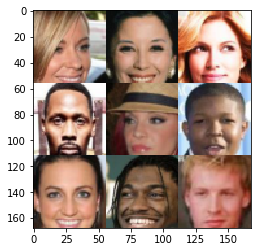

In [71]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np
import tensorflow as tf

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3
print(shape)

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        

test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images))

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. We are doing this to not clutter the training function any more than it already is. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [72]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

## The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

## Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:

**Conv1**
* 64 Filters, 5x5, Stride 2,
* BatchNorm,
* Leaky ReLU(alpha=0.01)

**Conv2**
* 128 Filters, 5x5, Stride 2.
* BatchNorm,
* Leaky ReLU(alpha=0.01)

**Conv3**
* 256 Filters, 5x5, Stride 1,
* BatchNorm,
* Leaky ReLU(alpha=0.01)

**Fully Connected Layer**

* Flatten
* Fully Connected size 4 x 4 x 256
* Fully Connected (Output) size 1

In [89]:
def discriminator(images, reuse=False,alpha = 0.01):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - images: TensorFlow Tensor of  input images, shape [batch_size, width,height,channels]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image and the sigmoid output with the same shape
    """
    with tf.variable_scope("discriminator",reuse=reuse):
        # TODO: implement architecture
        conv1 = tf.layers.Conv2D(filters=64, kernel_size=5, strides=2)
        conv2 = tf.layers.Conv2D(filters=128, kernel_size=5, strides=2)
        conv3 = tf.layers.Conv2D(filters=256, kernel_size=5, strides=1)
        batchnorm1 = tf.layers.BatchNormalization()
        batchnorm2 = tf.layers.BatchNormalization()
        batchnorm3 = tf.layers.BatchNormalization()
        img = conv1(images)
        img = batchnorm1(img)
        img = tf.nn.leaky_relu(img, alpha=alpha)
        img = conv2(img)
        img = batchnorm2(img)
        img = tf.nn.leaky_relu(img, alpha=alpha)
        img = conv3(images)
        img = batchnorm3(img)
        img = tf.nn.leaky_relu(img, alpha=alpha)
        
        img = tf.layers.Flatten()(img)
        img = tf.reshape(img, (-1,4,4,256))
        fc1 = tf.layers.Dense(units=4*4*256)
        img = fc1(img)
        fc2 = tf.layers.Dense(units=1)
        out = fc2(img)
        logits = tf.nn.sigmoid(out)
        return out,logits


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* out_channel_dim conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [91]:
def generator(z, out_channel_dim, reuse=False):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator", reuse=reuse):
        # TODO: implement architecture
        fc1 = tf.layers.Dense(units=1024)
        fc2 = tf.layers.Dense(units=7*7*128)
        batchnorm1 = tf.layers.BatchNormalization()
        batchnorm2 = tf.layers.BatchNormalization()
        batchnorm3 = tf.layers.BatchNormalization()
        conv1 = tf.layers.Conv2DTranspose(64, (4,4), 2)
        conv2 = tf.layers.Conv2DTranspose(out_channel_dim, (4,4), 2)
        
        img = fc1(z)
        img = tf.nn.relu(img)
        img = batchnorm1(img)
        img = fc2(img)
        img = batchnorm2(img)
        img = tf.reshape(img, (-1,7,7,128))
        img = conv1(img)
        img = batchnorm3(img)
        img = conv2(img)
        
        
        return img


## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [92]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    print(d_model_real, d_logits_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

## Optimization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [93]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [94]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(helper.images_square_grid(samples))
    pyplot.show()

## Training

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady - and we mean slowly but steady! This progress can take up some hours based on your setup.

In [95]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print(data_shape[3])
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])
                    
                    



### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

In [96]:
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

3
Tensor("discriminator/dense_1/BiasAdd:0", shape=(?, 4, 4, 1), dtype=float32) Tensor("discriminator/Sigmoid:0", shape=(?, 4, 4, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.6913


ValueError: Variable generator/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-91-572feef23cad>", line 20, in generator
    img = fc1(z)
  File "<ipython-input-92-83f735d57291>", line 8, in model_loss
    g_model = generator(input_z, out_channel_dim)
  File "<ipython-input-95-b87a732d4c11>", line 7, in train
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
